# Final Project Scene Classification

This dataset contains about ~25k images from a wide range of natural scenes from all around the world. The task is to identify which kind of scene can the image be categorized into.

It is a 6 class problem

Buildings
Forests
Mountains
Glacier
Street
Sea

In [1]:
import numpy as np 
import pandas as pd 
import random
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import classification_report,confusion_matrix

import keras
from keras import backend as K 
from keras.models import *
from keras.layers import *
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications import ResNet50
from keras.applications.vgg16 import VGG16

import tensorflow as tf
import os
from skimage import io

2023-06-24 13:44:04.110274: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Exploratory Data Analysis

In [7]:
test_data = pd.read_csv('../../../data/train-scene-classification/test.csv')
train_data = pd.read_csv('../../../data/train-scene-classification/train.csv')
train_data.head()

,image_name,label
0,0.jpg,0
1,1.jpg,4
2,2.jpg,5
3,4.jpg,0
4,7.jpg,4


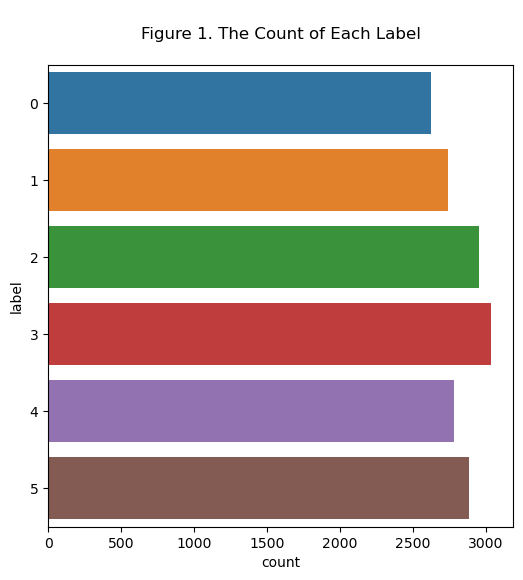

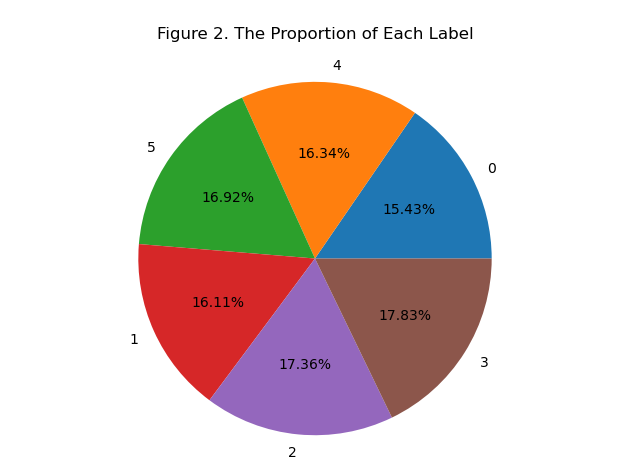

In [3]:
# plot the count of each label
fig, ax = plt.subplots(figsize=(6,6))
sns.countplot(data=train_data, y='label', ax=ax).set(title='\nFigure 1. The Count of Each Label\n')

# plot the proportion of each label
labels = train_data['label'].unique().tolist()
counts = train_data['label'].value_counts()
sizes = [counts[v] for v in labels]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%0.2f%%')
ax1.axis('equal')
plt.title("\nFigure 2. The Proportion of Each Label\n")
plt.tight_layout()
plt.show()

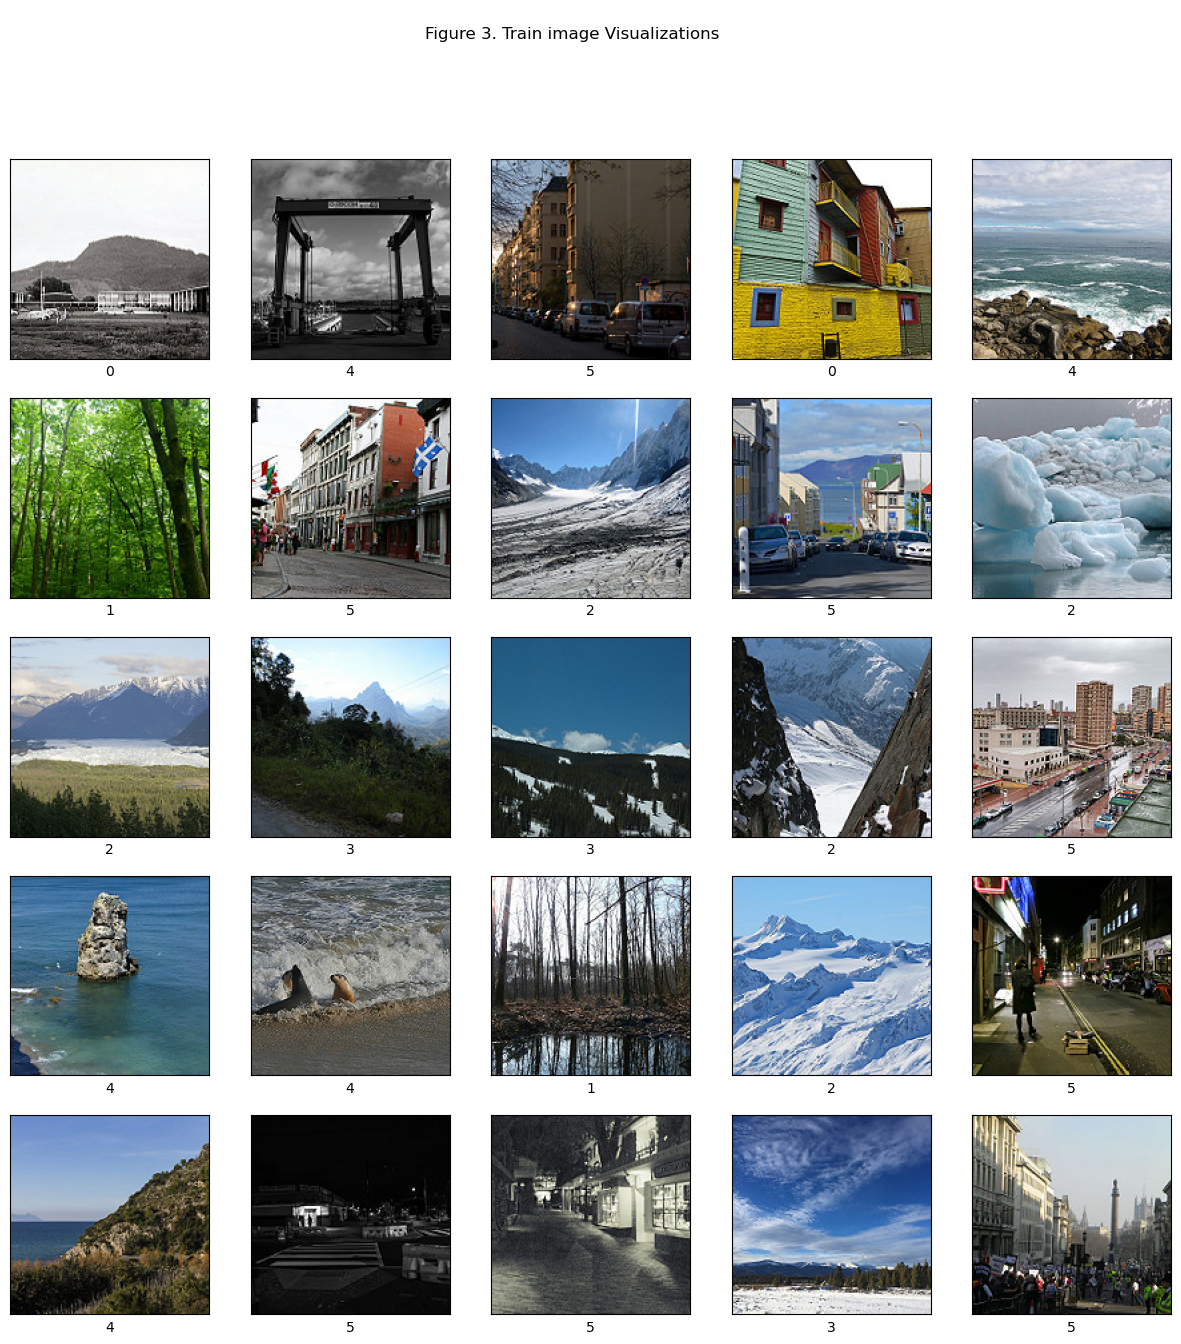

In [10]:
train_data["label"] = train_data["label"].astype(str)

fig, axes = plt.subplots(5, 5, figsize=(15, 15))
for i, ax in enumerate(axes.flat):
    file = str('../../../data/train-scene-classification/images/' + train_data.image_name[i])
    image = io.imread(file)
    ax.imshow(image)
    ax.set(xticks=[], yticks=[], xlabel = train_data.label[i])
fig.suptitle('\nFigure 3. Train image Visualizations') 
plt.show() 

## Model

In [11]:
train_data, valid_data = train_test_split(train_data,                                                       
                                   test_size=0.2, 
                                   shuffle=True, stratify=train_data["label"])

# check value count in train and validation set
print(train_data["label"].value_counts())
print(valid_data["label"].value_counts())

3    2430
2    2366
5    2306
4    2227
1    2196
0    2102
Name: label, dtype: int64
3    607
2    591
5    577
4    557
1    549
0    526
Name: label, dtype: int64


In [13]:
datagen = ImageDataGenerator(featurewise_center=False,  # set input mean to 0 over the dataset                           
                             zoom_range = 0.2, # Randomly zoom image 
                             rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
                             width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
                             height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
                             horizontal_flip = True,  # randomly flip images
                             rescale=1./255)    # multiply the data by the value provided

train_generator = datagen.flow_from_dataframe(
                            dataframe=train_data,
                            directory='../../../data/train-scene-classification/images/',
                            x_col="image_name",
                            y_col="label",                            
                            class_mode="categorical",
                            target_size=(64,64))
validation_generator = datagen.flow_from_dataframe(
                            dataframe=valid_data,
                            directory='../../../data/train-scene-classification/images/',
                            x_col="image_name",
                            y_col="label",
                            class_mode="categorical",
                            target_size=(64,64))

Found 13627 validated image filenames belonging to 6 classes.
Found 3407 validated image filenames belonging to 6 classes.


In [21]:
model = Sequential()
# first convolutional layer
model.add(Conv2D(32, (3, 3), input_shape=(64,64,3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# second convolutional layer
model.add(Conv2D(64, (3, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
  
# third convolutional layer
model.add(Conv2D(128, (3, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.4))

# Out layer
model.add(Dense(6))
model.add(Activation('softmax'))

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 62, 62, 32)        896       
                                                                 
 batch_normalization_20 (Bat  (None, 62, 62, 32)       128       
 chNormalization)                                                
                                                                 
 activation_25 (Activation)  (None, 62, 62, 32)        0         
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 31, 31, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 29, 29, 64)        18496     
                                                                 
 batch_normalization_21 (Bat  (None, 29, 29, 64)      

In [22]:
opt = Adam(learning_rate=0.0001)
model.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [24]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=validation_generator.n//validation_generator.batch_size
history = model.fit(train_generator,
                    epochs = 5, 
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data = validation_generator,
                    validation_steps=STEP_SIZE_VALID)

Epoch 1/5


2023-06-24 15:59:35.699471: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


425/425 [==============================] - ETA: 0s - loss: 0.2456 - accuracy: 0.6868

2023-06-24 16:02:11.776310: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


425/425 [==============================] - 190s 447ms/step - loss: 0.2456 - accuracy: 0.6868 - val_loss: 0.2115 - val_accuracy: 0.7388
Epoch 2/5
425/425 [==============================] - 219s 515ms/step - loss: 0.2328 - accuracy: 0.7090 - val_loss: 0.2094 - val_accuracy: 0.7341
Epoch 3/5
425/425 [==============================] - 148s 348ms/step - loss: 0.2190 - accuracy: 0.7273 - val_loss: 0.2121 - val_accuracy: 0.7270
Epoch 4/5
425/425 [==============================] - 167s 392ms/step - loss: 0.2102 - accuracy: 0.7409 - val_loss: 0.1939 - val_accuracy: 0.7556
Epoch 5/5
425/425 [==============================] - 139s 327ms/step - loss: 0.2058 - accuracy: 0.7478 - val_loss: 0.1816 - val_accuracy: 0.7715


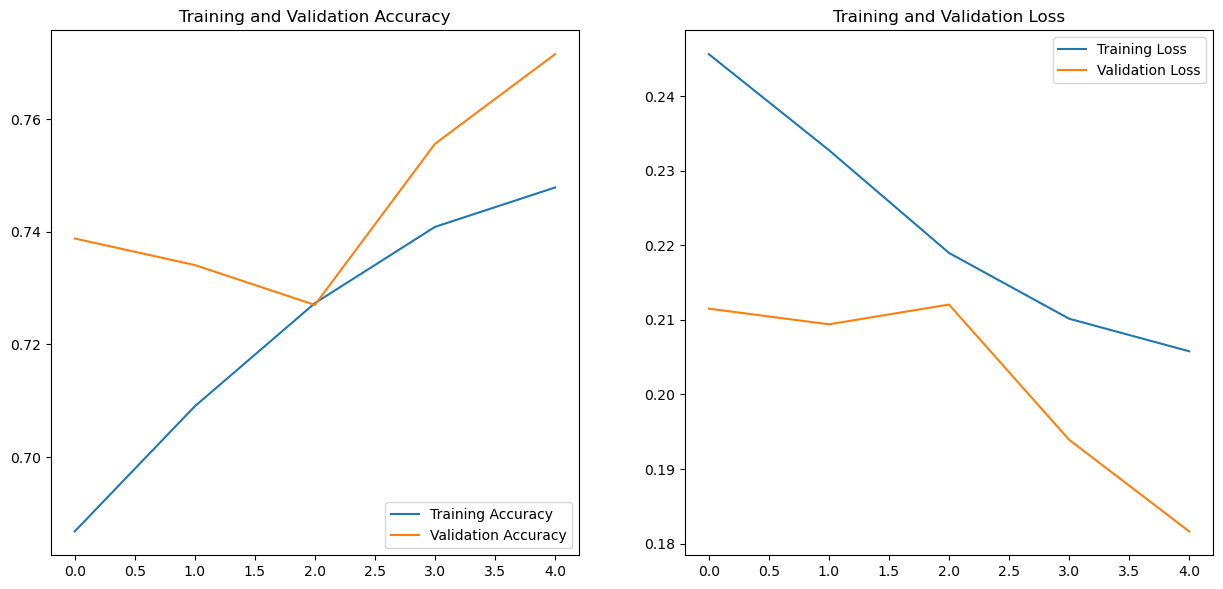

In [26]:
#model.save("my_model1")
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(5)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [28]:
val_loss1, val_acc1 = model.evaluate(validation_generator)
print('val_loss_model1:', val_loss1)
print('val_acc_model1:', val_acc1)
predictions1 = model.predict(validation_generator, verbose=1)
predictions1

2023-06-24 16:23:23.268524: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


107/107 [==============================] - 23s 213ms/step - loss: 0.1827 - accuracy: 0.7737
val_loss_model1: 0.182684063911438
val_acc_model1: 0.7737011909484863


2023-06-24 16:23:46.285998: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


107/107 [==============================] - 22s 206ms/step


array([[1.46966934e-01, 3.61610860e-01, 3.35849239e-03, 8.20452929e-04,
        4.12595866e-04, 4.86830711e-01],
       [1.34276692e-02, 8.47113609e-01, 8.16544611e-03, 2.96359765e-03,
        3.17074358e-03, 1.25158980e-01],
       [2.22807983e-04, 1.05757346e-04, 3.17513477e-04, 1.57974195e-04,
        1.52824014e-05, 9.99180615e-01],
       ...,
       [7.11396744e-04, 7.69755061e-05, 1.03727134e-05, 5.50130644e-05,
        4.60099272e-06, 9.99141693e-01],
       [2.85999179e-02, 1.18645432e-03, 4.90507018e-03, 1.01458328e-03,
        1.64281148e-02, 9.47865844e-01],
       [5.67715093e-02, 2.51426071e-01, 1.04332995e-02, 6.38803886e-03,
        1.91881452e-02, 6.55792892e-01]], dtype=float32)

In [43]:
y_pred = []
for pred in predictions1:
    y_pred.append(pred.argmax())

In [51]:
valid_data['label'].astype(int)

37       0
15714    0
16774    4
1218     2
10488    0
        ..
9554     2
8627     0
11119    3
16043    4
1815     1
Name: label, Length: 3407, dtype: int64

              precision    recall  f1-score   support

   Buildings       0.17      0.17      0.17       526
     Forests       0.14      0.15      0.14       549
   Mountains       0.16      0.14      0.15       591
     Glacier       0.17      0.18      0.18       607
      Street       0.15      0.15      0.15       557
         Sea       0.15      0.16      0.16       577

    accuracy                           0.16      3407
   macro avg       0.16      0.16      0.16      3407
weighted avg       0.16      0.16      0.16      3407



<Axes: >

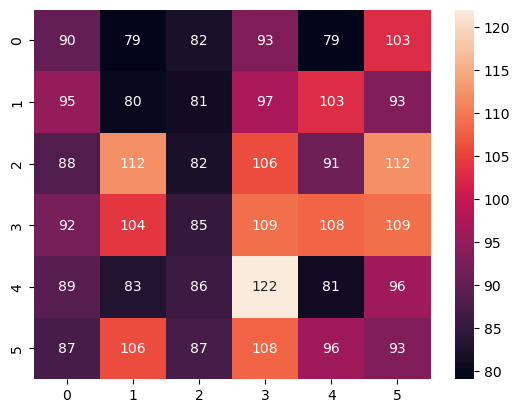

In [53]:
#y_pred1 = np.where(predictions1 > 0.5, 1, 0)
print(classification_report(valid_data['label'].astype(int), y_pred, target_names = ['Buildings','Forests','Mountains','Glacier','Street','Sea']))
cm1 = confusion_matrix(valid_data['label'].astype(int), y_pred)
sns.heatmap(cm1, annot=True, fmt=".0f")